# 기본 분류 - 영화 리뷰를 사용한 텍스트 분류(with IMDB)

## 0. 기본 라이브러리 불러오기

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
print(tf.__version__)

2.3.0


## 1. 감정 분석

이 예시는 리뷰 텍스트를 사용하여 영화 리뷰를 <span style='background-color:#fff5b1'>긍정적 또는 부정적</span>으로 분류한다.<br/>
중요하고 널리 적용 가능한 머신러닝 문제인 <span style='background-color:#fff5b1'>이진 분류 문제</span>이다.

[IMDB 데이터세트](https://ai.stanford.edu/~amaas/data/sentiment/)에는 [인터넷 영화 데이터베이스](https://www.imdb.com/)에서 가져온 50,000개의 영화 리뷰 텍스트가 포함되어있다.<br/>
훈련용 리뷰 25,000개와 테스트용 리뷰 25,000개로 나뉜다.<br/>
훈련 및 테스트 세트는 균형을 이룬다. 즉, <span style='background-color:#fff5b1'>동일한 수의 긍정적인 리뷰와 부정적인 리뷰가 포함되어 있다.</span>

### 1-1 데이터세트 다운로드 및 탐색

데이터 세트를 다운로드하여 추출한 다음 디렉터리 구조를 살펴보자.

In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("acImdb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [5]:
os.listdir(dataset_dir)

['test', 'imdbEr.txt', 'README', 'train', 'imdb.vocab']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'urls_neg.txt',
 'urls_pos.txt',
 'neg',
 'unsup']

```aclImdb/train/pos``` 와 ```aclImdb/train/neg``` 디렉토리에는 각각 단일 영화를 리뷰한 많은 텍스트 파일이 포함되어 있다. 그 중 하나를 살펴보자.

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 1-2 데이터세트 로드하기

다음으로, 디스크에서 데이터세트를 로드하고 훈련에 적합한 형식으로 준비한다.<br/>
이를 위해 다음과 같은 디렉토리 구조를 예상하는 유용한 [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory?hl=ko)유틸리티를 사용한다.

main_directory/<br/>
...class_a/<br/>
......a_text_1.txt<br/>
......a_text_2.txt<br/>
...class_b/<br/>
......b_text_1.txt<br/>
......b_text_2.txt<br/>

이진분류를 위한 데이터세트를 준비하려면 ```class_a``` 및 ```class_b``` 에 해당하는 두 개의 폴더가 필요하다.<br/>
이것들은 ```aclImdb/train/pos``` 및 ```aclImdb/train/neg``` 에서 찾을 수 있는 긍정적 영화 리뷰와 부정적 영화 리뷰이다.<br/>
IMDB 데이터세트에는 추가 폴더가 포함되어 있으므로 이 유틸리티를 사용하기 전에 제거한다.

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

다음으로 ```text_dataset_from_directory``` 유틸리티를 사용하여 레이블이 지정된 ```tf.data.Dataset``` 을 만든다.<br/>
```tf.data``` 는 데이터 작업을 위한 강력한 도구 모음이다.<br/>

<span style='background-color:#fff5b1'>머신러닝 실험을 진행 할 때, 데이터세트를 ```train```, ```validation```, ```test``` 세 부분으로 나누는 것이 제일 좋다.</span>

IMDB 데이터세트는 이미 훈련과 테스트로 나누어져 있지만 검증 세트가 부족하다.<br/>
```validation_split``` 인수를 사용하여 훈련 데이터를 80:20으로 분할하여 검증 세트를 생성해보자.

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                  batch_size=batch_size,
                                                                  validation_split=0.2,
                                                                  subset='training',
                                                                  seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


training 폴더에는 25,000개의 예제가 있으며, 그 중 80%(20,000개)를 훈련에 사용 할 것이다.<br/>
잠시후에 알 수 있겠지만 데이터세트를 ```model.fit``` 에 직접 전달하여 모델을 훈련할 수 있다.<br/>
[```tf.data```](https://www.tensorflow.org/api_docs/python/tf/data?hl=ko)를 처음 사용하는 경우 데이터세트를 반복하고 다음과 같은 몇 가지 예를 출력할 수도 있다.

In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

리뷰에는 ```<br/>``` 과 같은 간헐적 HTML태그와 구두점을 포함한 원시 텍스트 데이터가 포함되어있다는 점에 주목하자.<br/>
다음 섹션에서 이를 처리하는 방법을 보여준다.

레이블은 0 또는 1이다. 이들 중 어느 것이 긍정적이고 부정적인 영화리뷰에 해당하는지 확인하려면 데이터세트에서 ```class_names``` 속성을 확인할 수 있다.

In [11]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


다음으로, 검증 및 테스트 데이터세트를 만든다.<br/>
검증을 위해 훈련 세트의 나머지 5000개 리뷰를 사용한다.

In [12]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/train',
                                                                batch_size=batch_size,
                                                                validation_split=0.2,
                                                                subset='validation',
                                                                seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('aclImdb/test',
                                                                 batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 1-3 훈련을 위한 데이터세트 준비하기

다음으로, 유용한 ```tf.keras.layers.TextVectorization``` 레이어를 사용하여 데이터를 <span style='background-color:#fff5b1'>표준화, 토큰화 및 벡터화 한다.</span>

<span style='background-color:#ffdce0'>표준화</span>는 <span style='background-color:#ffdce0'>일반적으로 구두점이나 HTML 요소를 제거하여 데이터세트를 단순화하기 위해 텍스트를 전처리하는 것을 말한다.</span><br/>
<span style='background-color:#ffdce0'>토큰화</span>는 문자열을 여러 토큰으로 분할하는 것을 말한다.</span>(ex. 화이트스페이스에서 분할하여 문장을 개별단어로 분할)<br/>
<span style='background-color:#ffdce0'>벡터화</span>는 <span style='background-color:#ffdce0'>토큰을 숫자로 분할하여 신경망에 공급될 수 있도록 하는 것을 말한다.</span><br/>
이러한 모든 작업을 이 레이어에서 수행할 수 있다.

위에서 볼 수 있듯이, 리뷰에는 ```<br/>```와 같은 다양한 HTML태그가 포함되어 있다.<br/>
이러한 태그는 ```TextVectorization``` 레이어의 기본 표준화 도구로 제거되지 않는다.(텍스트를 소문자로 변환하고 구두점은 제거하지만 HTML은 제거하지 않음)<br/>
HTML을 제거하기 위해 사용자 정의 표준화 함수를 작성한다.

<참고><br/>
[훈련-테스트 왜곡]()(훈련-제공 왜곡이라고도 함)을 방지하려면 훈련 및 테스트 시간에 데이터를 동일하게 전처리 하는것이 중요하다.<br/>
이를 용이하게 하기 위해 ```TextVectorization``` 레이어를 모델 내에 직접 포함할 수 있다.

In [14]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br/ >', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

다음으로 ```TextVectorization``` 레이러를 만든다.<br/>
<span style='background-color:#ffdce0'>이 레이어를 사용하여 데이터를 표준화, 토큰화 및 벡터화 한다.</span><br/>
각 토큰에 대해 고유한 정수 인덱스를 생성하도록 ```output_mode```를 ```int``` 로 설정한다.

기본 분할 함수와 위에서 정의한 사용자 지정 표준화 함수를 사용하고 있다.<br/>
명시적 최댓값인 ```sequence_length```와 같이 모델에 대한 몇가지 상수를 정의하여 레이어가 시퀀스를 정확히 ```sequence_length```값으로 채우거나 자르도록 한다.

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(standardize=custom_standardization,
                                                                               max_tokens=max_features,
                                                                               output_mode='int',
                                                                               output_sequence_length=sequence_length)

다음으로, 전처리 레이어의 상태를 데이터세트에 맞추기 위해 ```adapt```를 호출한다.<br/>
그러면 모델이 문자열 인덱스를 정수로 빌드업한다.

<참고><br/>
```adapt```를 호출할 때 훈련 데이터만 사용하는것이 중요하다.(테스트 데이터를 사용하면 정보가 누출됨)

In [16]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

이 레이어를 사용하여 일부 데이터를 전처리한 결과를 확인하는 함수를 만들어보자.

In [17]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [18]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

위에서 볼 수 있듯이 각 토큰은 정수로 대체되었다.<br/>
레이어에서 ```.get_vocabulary()```를 호출하여 각 정수에 해당하는 토큰(문자열)을 조회할 수 있다.

In [19]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  naked
 313 --->  night
Vocabulary size: 10000


모델을 훈련할 준비가 거의 되었다.<br/>
<span style='background-color:#fff5b1'>최종 전처리 단계로 이전에 생성한 TextVectorization 레이어를 훈련, 검증, 테스트 데이터세트에 적용한다.</span>

In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 1-4 성능을 높이도록 데이터세트 구성하기

다음은 I/O가 차단되지 않도록 데이터를 로드할 때 사용해야 하는 두가지 중요한 메서드이다.<br/>
1. ```.cache()```는 데이터가 디스크에서 로드된 후 메모리에 데이터를 보관한다. 이렇게 하면 모델을 훈련하는 동안 데이터세트로 인해 병목현상이 발생하지 않는다.<br/>데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 뛰어난 온 디스크 캐시를 생성할 수도 있다.<br/>많은 작은 파일보다 읽기가 더 효율적이다.
2. ```.prefetch()```는 훈련중에 데이터 전처리 및 모델 실행과 겹친다.<br/><br/>

[데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance?hl=ko)에서 두 가지 메서드와 데이터를 디스크에 캐싱하는 방법에 관해 자세하게 알아볼 수 있다.

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 1-5 모델 생성

In [22]:
embedding_dim = 16

In [23]:
model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


층을 순서대로 쌓아 분류기(classifier)를 만든다.<br/>
1. 첫 번째 레이어는 ```Embedding``` 레이어이다. 이 레이어는 정수로 인코딩된 리뷰를 입력 받고 각 단어 인덱스에 해당하는 임베딩 벡터를 찾는다.<br/>이러한 벡터는 모델이 훈련되면서 학습된다. 이들 벡터는 출력 배열에 차원을 추가한다.<br/>최종 차원은 ```(batch, sequence, embedding)```이 된다. 임베딩에 대해 보다 자세히 알아보고 싶다면, [단어 임베딩](https://www.tensorflow.org/text/guide/word_embeddings?hl=ko)튜토리얼을 확인하자.
2. 그 다음 ```GlobalAveragePooling1d```층은 ```sequence``` 차원에 대해 평균을 계산하여 각 샘플에 대해 고정된 길이의 출력 벡터를 반환한다.<br/>이는 길이가 다른 입력을 다루는 가장 간단한 방법이다.
3. 이 고정 길이의 출력 벡터는 16개의 은닉 유닛을 가진 완전연결층(```Dense```)을 거친다.
4. 마지막 층은 하나의 출력 노드를 가진 완전연결층(```Dense```)이다.<br/>```sigmoid```함수를 사용하여 0~1의 실수를 출력한다. 이 값은 확률 또는 신뢰도를 나타낸다.

### 1-6 손실 함수와 옵티마이저

<span style='background-color:#fff5b1'>모델이 훈련하려면 손실 함수(loss function)과 옵티마이저(optimizer)가 필요하다.</span><br/>
이 예제는 이진 분류 문제이고 모델이 확률을 출력하므로(출력층의 유닛이 1이고 ```sigmoid```활성화 함수를 사용), ```binary_crossentropy``` 손실함수를 사용하자.<br/>

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 1-7 모델 훈련하기

```dataset``` 개체를 fit 메서드에 전달하여 모델을 훈련한다.

In [25]:
epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 5s 8ms/step - loss: 0.6635 - binary_accuracy: 0.6897 - val_loss: 0.6139 - val_binary_accuracy: 0.7742
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5482 - binary_accuracy: 0.7991 - val_loss: 0.4984 - val_binary_accuracy: 0.8190
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4457 - binary_accuracy: 0.8431 - val_loss: 0.4215 - val_binary_accuracy: 0.8470
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3801 - binary_accuracy: 0.8650 - val_loss: 0.3758 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3373 - binary_accuracy: 0.8773 - val_loss: 0.3473 - val_binary_accuracy: 0.8660
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3067 - binary_accuracy: 0.8873 - val_loss: 0.3285 - val_binary_accuracy: 0.8708
Epoch 7/10
625/625 [==============================] - 5s 8ms/ste

### 1-8 모델 평가하기

모델의 성능을 평가해보자.<br/>
<span style='background-color:#fff5b1'>손실과 정확도 두 개의 값이 반환된다.</span>

In [26]:
loss, accuracy = model.evaluate(test_ds)

print('Loss :', loss)
print('Accuracy :', accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3130 - binary_accuracy: 0.8718
Loss : 0.313039094209671
Accuracy : 0.8718000054359436


상당히 단순한 접근방식은 약 87%의 정확도를 달성한다.

### 1-9 정확도와 손실 그래프 그리기

```model.fit()```은 훈련 중에 발생한 모든 것을 가진 사전을 포함하는 ```History``` 객체를 반환한다.

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

훈련과 검증 단계에서 모니터링 하는 지표 4개의 항목이 있다.<br/>
훈련 손실과 검증 손실을 그래프로 그려보고, 훈련 정확도와 검증 정확도도 그래프로 그려 비교해보자.

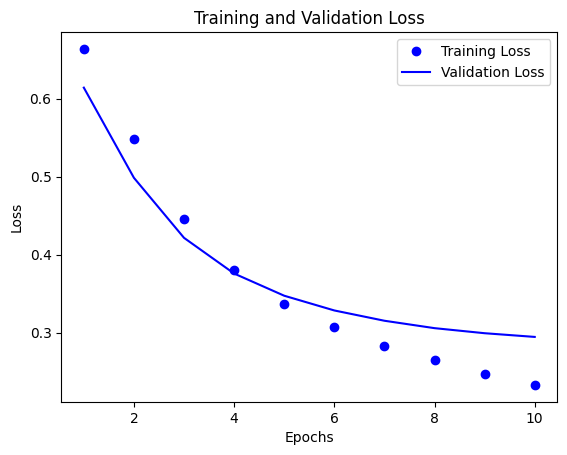

In [28]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

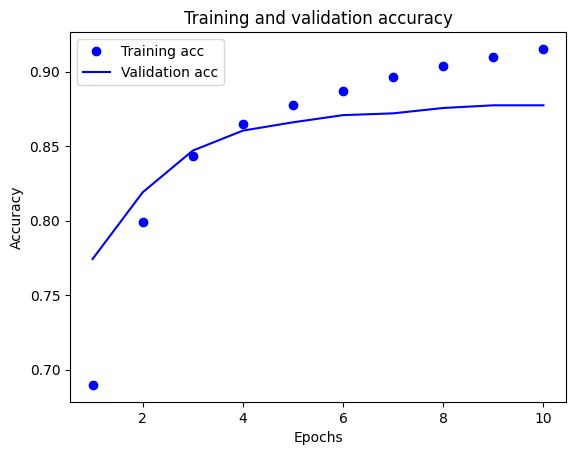

In [29]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

위 그래프들에서 점선은 훈련 손실과 훈련 정확도를 나타내고, 실선은 검증 손실과 검증 정확도를 나타낸다.

훈련 손실은 각 epoch마다 감소하고 훈련 정확도는 각 epoch마다 증가한다.<br/>
하지만 <span style='background-color:#fff5b1'>과대적합 때문에 검증 손실과 검증 정확도가 빠르게 향상되지 않는다.</span><br/>
이전에 본 적 없는 데이터보다 훈련 데이터에서 모델이 더 잘 동작한다.<br/>
<span style='background-color:#fff5b1'>이 지점부터는 모델이 과도하게 최적화되어 테스트 데이터에서 일반화되지 않는 훈련 데이터의 특정 표현을 학습한다.</span>

여기에서는 과대적합을 막기 위해 단순히 검증 정확도가 더이상 증가하지 않는 경우에 훈련을 중단할 수 있다.<br/>
이를 수행하는 한 가지 방법은 [```tf.keras.callbacks.EarlyStopping```](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping?hl=ko) 콜백을 사용하는 것이다.

### 1-10 모델 내보내기

위의 코드에서는 모델에 텍스트를 제공하기 전에 ```TextVectorization``` 레이어를 데이터세트에 적용했다.<br/>
모델이 원시 문자열을 처리할 수 있도록 하려면(배포를 단순화하기 위해) 모델 내부에 ```TextVectorization``` 레이어를 포함할 수 있다.<br/>
이를 위해 방금 훈련한 가중치를 사용하여 새 모델을 만들 수 있다.

In [30]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
                     optimizer='adam',
                     metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 5s 6ms/step - loss: 0.3130 - accuracy: 0.8718
0.8718000054359436


### 1-11 새로운 데이터로 추론하기

새로운 예에 대한 예측을 얻을라면 간단히 ```model.predict()```를 호출하면 된다.

In [31]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6348033 ],
       [0.46174204],
       [0.37344804]], dtype=float32)

모델 내부에 텍스트 전처리 논리를 포함하면 배포를 단순화하고 [훈련/테스트 왜곡](https://developers.google.com/machine-learning/guides/rules-of-ml?hl=ko#training-serving_skew) 가능성을 줄이는 프로덕션용 모델을 내보낼 수 있다.

TextVectorization 레이어를 적용할 위치를 선택할 때 염두에 두어야 할 성능 차이가 있다.<br/>
레이어를 모델 외부에서 사용하면 GPU에서 훈련할 때 비동기 CPU 처리 및 데이터 버퍼링을 수행할 수 있다.<br/>
따라서 GPU에서 모델을 훈련하는 경우 모델을 개발하는 동안 최상의 성능을 얻기 위해 이 옵션을 사용하고<br/>
배포 준비가 완료되면 모델 내부에 TextVectorization 레이어를 포함하도록 전환할 수 있다.

모델 저장에 대해 자세히 알아보려면 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko)을 방문해보자.